# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go

In [2]:
keras = tf.keras
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00580/hungary_chickenpox.zip"

In [3]:
# download and unzip required file
import requests, zipfile, io
r = requests.get(URL)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content/chickenpox")

In [4]:
# read the files
train_df = pd.read_csv('/content/chickenpox/hungary_chickenpox.csv')
test_df = pd.read_csv('/content/chickenpox/hungary_county_edges.csv')

In [5]:
train_df['TOTAL'] = train_df.iloc[:,1:].sum(axis=1)

In [6]:
train_df.shape

(522, 22)

# Visual extraction of data

In [7]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=5)
    plt.grid(True)


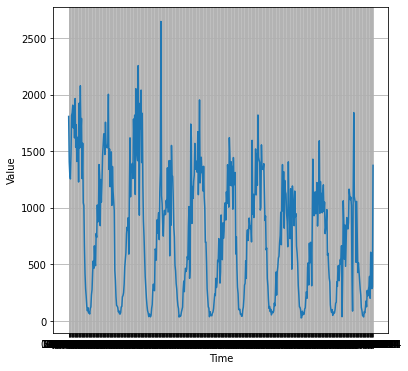

In [8]:
time = np.array(train_df['Date'])
series = train_df['TOTAL'] 
plt.figure(figsize=(6,6))
plot_series(time,series)
plt.show()

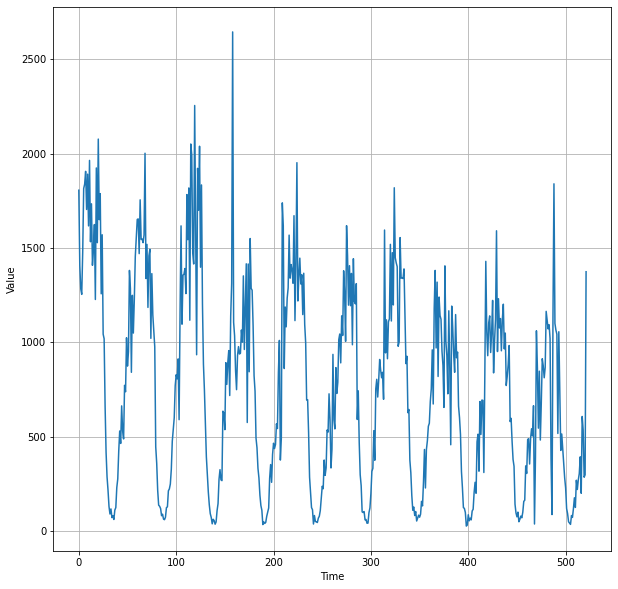

In [9]:
# discarded the date object with integers
# done to find where to split data 
time = np.arange(0,522) 
series = train_df['TOTAL']
plt.figure(figsize=(10,10))
plot_series(time,series)
plt.show()

In [10]:
fig = go.Figure(go.Scatter(
    x=time,
     y=series,
     name = "Total cases Data"))
fig.show()

In [11]:
# splitting series into training and validation split since data is less 
time_split = 400
time_train = time[:time_split]
x_train = series[:time_split]
time_val = time[time_split:]
x_val = series[time_split:]

# Moving Average

In [12]:
def moving_average(series,window_size):
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size-1:-1]/window_size 

In [13]:
series = np.array(series)
moving_avg = moving_average(series,10)[time_split-10:]

All of our models are basic models where we have to hardcode most of the things into functions. Currently the best method to provide least mean absolute error is <b>difference moving average</b> .

Minimum Mean Absolute Error observed : 170.4610655737705


<hr>

# Basic ML implementation 

In [14]:
# window dataset function to create more datasets and group them together
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # if size here is n+1
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # this breaks into [n] [1]
    dataset = dataset.batch(batch_size).prefetch(1) # group m number of windows together
    return dataset

In [15]:
time_split = 418
time_train = time[:time_split]
x_train = series[:time_split]
time_val = time[time_split:]
x_val = series[time_split:]

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 10
train_set = window_dataset(x_train,window_size,batch_size=13)
valid_set = window_dataset(x_val,window_size,batch_size=13)

## model 1

In [ ]:
model = keras.models.Sequential([
     keras.layers.Dense(1,input_shape = [window_size])                            
])

optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum = 0.9)
model.compile(optimizer=optimizer,loss=keras.losses.Huber(),metrics=["mae"])
model.fit(train_set,epochs= 50,validation_data=valid_set)

Epoch 1/50
32/32 [==============================] - 1s 8ms/step - loss: 2336.6230 - mae: 2337.1229 - val_loss: 824.5695 - val_mae: 825.0695
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 942.5483 - mae: 943.0482 - val_loss: 396.5334 - val_mae: 397.0334
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 510.1760 - mae: 510.6732 - val_loss: 350.8711 - val_mae: 351.3711
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 433.4607 - mae: 433.9607 - val_loss: 315.4071 - val_mae: 315.9071
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 379.3760 - mae: 379.8756 - val_loss: 282.0471 - val_mae: 282.5471
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 333.0207 - mae: 333.5188 - val_loss: 254.3437 - val_mae: 254.8437
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 293.5919 - mae: 294.0919 - val_loss: 227.4062 - val_mae: 227.9062
Epoch 8/50
32/32 [==============

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 10
train_set = window_dataset(x_train,window_size,13)

model = keras.models.Sequential([
       keras.layers.Dense(1,input_shape = [window_size])                          
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 30))

optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)

model.compile(optimizer=optimizer,loss=keras.losses.Huber(),metrics=["mae"])
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
32/32 [==============================] - 3s 3ms/step - loss: 1182.7394 - mae: 1183.2394
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 1058.4380 - mae: 1058.9380
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 1108.3001 - mae: 1108.8001
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 1058.3018 - mae: 1058.8018
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 1033.8878 - mae: 1034.3876
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 1047.5232 - mae: 1048.0232
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 969.5689 - mae: 970.0689
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 992.2450 - mae: 992.7449
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 977.0571 - mae: 977.5571
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 948.0176 - mae: 948.5176
Epoch 1

(1e-08, 0.001, 0.0, 500.0)

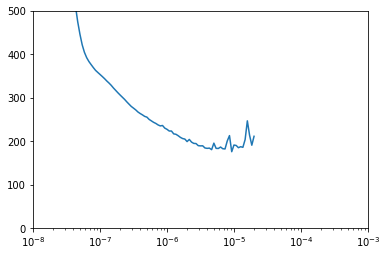

In [18]:
plt.semilogx(history.history["lr"],history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 500])


the graph above shows that lr of 1e-6 is good for this dataset

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 10
train_set = window_dataset(x_train,window_size,13)
valid_set = window_dataset(x_val,window_size,13)

model = keras.models.Sequential([
       keras.layers.Dense(1,input_shape = [window_size])                          
])

optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)
model.compile(optimizer=optimizer,loss=keras.losses.Huber(),metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=7)

history = model.fit(train_set,epochs=200,validation_data=valid_set,callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 1s 16ms/step - loss: 2336.6230 - mae: 2337.1229 - val_loss: 824.5695 - val_mae: 825.0695
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 942.5483 - mae: 943.0482 - val_loss: 396.5334 - val_mae: 397.0334
Epoch 3/200
32/32 [==============================] - 0s 4ms/step - loss: 510.1760 - mae: 510.6732 - val_loss: 350.8711 - val_mae: 351.3711
Epoch 4/200
32/32 [==============================] - 0s 4ms/step - loss: 433.4607 - mae: 433.9607 - val_loss: 315.4071 - val_mae: 315.9071
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 379.3760 - mae: 379.8756 - val_loss: 282.0471 - val_mae: 282.5471
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 333.0207 - mae: 333.5188 - val_loss: 254.3437 - val_mae: 254.8437
Epoch 7/200
32/32 [==============================] - 0s 4ms/step - loss: 293.5919 - mae: 294.0919 - val_loss: 227.4062 - val_mae: 227.9062
Epoch 8/200
32/32 [=====

In [20]:
def model_forecast(model, series, window_size): # function created to get predicted output
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [21]:
time_split = 418
lin_forecast = model_forecast(model, series[time_split - window_size:-1], window_size)[:, 0]


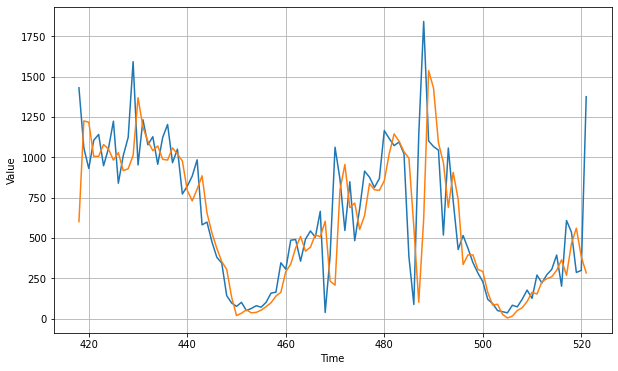

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, lin_forecast)

In [23]:
keras.metrics.mean_absolute_error(x_val, lin_forecast).numpy()

178.96135

This basic layering is almost same as naive forecasting but slightly better, let's see how much can we reduce this with multi Dense layers , RNN and CNN implementations


In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 10
train_set = window_dataset(x_train,window_size,13)

model = keras.models.Sequential([                                  
       keras.layers.Dense(8,activation="relu",input_shape = [window_size]),               
       keras.layers.Dense(3,activation="relu"),
       keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)

model.compile(optimizer=optimizer,loss=keras.losses.Huber(),metrics=["mae"])
history = model.fit(train_set,epochs=150,callbacks=[lr_schedule])

Epoch 1/150
32/32 [==============================] - 0s 3ms/step - loss: 1248.0030 - mae: 1248.5030
Epoch 2/150
32/32 [==============================] - 0s 3ms/step - loss: 1253.4780 - mae: 1253.9779
Epoch 3/150
32/32 [==============================] - 0s 3ms/step - loss: 1279.8409 - mae: 1280.3409
Epoch 4/150
32/32 [==============================] - 0s 3ms/step - loss: 1192.1192 - mae: 1192.6192
Epoch 5/150
32/32 [==============================] - 0s 2ms/step - loss: 1177.4019 - mae: 1177.9019
Epoch 6/150
32/32 [==============================] - 0s 2ms/step - loss: 1244.3922 - mae: 1244.8922
Epoch 7/150
32/32 [==============================] - 0s 3ms/step - loss: 1162.8996 - mae: 1163.3996
Epoch 8/150
32/32 [==============================] - 0s 2ms/step - loss: 1216.7312 - mae: 1217.2312
Epoch 9/150
32/32 [==============================] - 0s 2ms/step - loss: 1196.4305 - mae: 1196.9305
Epoch 10/150
32/32 [==============================] - 0s 2ms/step - loss: 1138.3980 - mae: 1138.8980

(1e-08, 0.005, 0.0, 500.0)

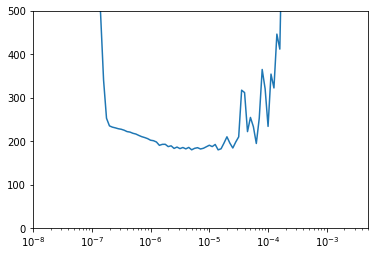

In [25]:
plt.semilogx(history.history["lr"],history.history["loss"])
plt.axis([1e-8, 5e-3, 0,500])

1e-6 works good for a learning rate

In [26]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 5 # decreased window size from 10 -> 5
train_set = window_dataset(x_train,window_size,13)
valid_set = window_dataset(x_val,window_size,13)

model = keras.models.Sequential([                                  
       keras.layers.Dense(8,activation="relu",input_shape = [window_size]),               
       keras.layers.Dense(3,activation="relu"),
       keras.layers.Dense(1)
])

early_stopping = keras.callbacks.EarlyStopping(patience=10)

optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)

model.compile(optimizer=optimizer,loss=keras.losses.Huber(),metrics=["mae"])
history = model.fit(train_set,epochs=500,validation_data=valid_set,callbacks=[early_stopping])

Epoch 1/500
32/32 [==============================] - 1s 14ms/step - loss: 786.9960 - mae: 787.4960 - val_loss: 449.6656 - val_mae: 450.1656
Epoch 2/500
32/32 [==============================] - 0s 4ms/step - loss: 481.8076 - mae: 482.3073 - val_loss: 192.0719 - val_mae: 192.5709
Epoch 3/500
32/32 [==============================] - 0s 4ms/step - loss: 222.0593 - mae: 222.5588 - val_loss: 187.6484 - val_mae: 188.1464
Epoch 4/500
32/32 [==============================] - 0s 4ms/step - loss: 223.2063 - mae: 223.7056 - val_loss: 184.9342 - val_mae: 185.4342
Epoch 5/500
32/32 [==============================] - 0s 4ms/step - loss: 221.7268 - mae: 222.2261 - val_loss: 180.8322 - val_mae: 181.3322
Epoch 6/500
32/32 [==============================] - 0s 4ms/step - loss: 215.5397 - mae: 216.0396 - val_loss: 178.9548 - val_mae: 179.4548
Epoch 7/500
32/32 [==============================] - 0s 4ms/step - loss: 209.6745 - mae: 210.1744 - val_loss: 177.8159 - val_mae: 178.3157
Epoch 8/500
32/32 [=======

In [27]:
dense_forecast = model_forecast(
    model,
    series[time_split - window_size:-1],
    window_size)[:, 0]

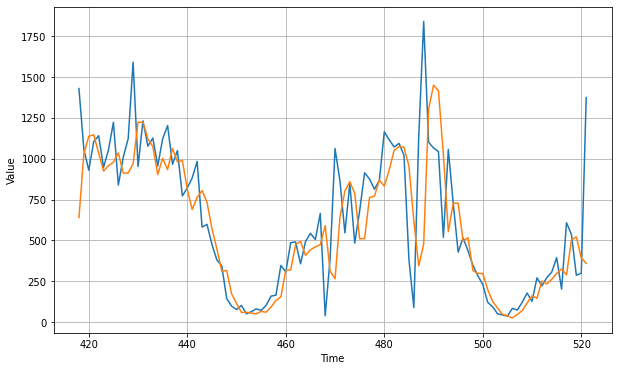

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, dense_forecast)

In [29]:
keras.metrics.mean_absolute_error(x_val,dense_forecast).numpy()
# we recieved this even before preprocessing here

174.74289

This is a good score but not the best model.